# Challenge: Make Your Own Regression Model
Unit 2 / Lesson 4 / Project 4

Now that you've spent some time playing with a sample multivariate linear regression model, it's time to make your own.

You've already gotten started by prepping the [FBI:UCR Crime dataset](https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls) ([Thinkful mirror](https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv)) in a previous assignment.

Using this data, build a regression model to predict property crimes.
You can use the features you prepared in the previous assignment, new features of your own choosing, or a combination.
The goal here is prediction rather than understanding mechanisms, so the focus is on creating a model that explains a lot of variance.

Include a brief writeup of your feature engineering and selection process.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
import seaborn as sns
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import statsmodels.formula.api as smf

# suppress annoying harmless error
import warnings
warnings.filterwarnings(action='ignore', module='scipy', message='^internal gelsd')
warnings.filterwarnings("ignore",category =RuntimeWarning)

In [2]:
# load data
PATH = ('nyc_crime_data.csv')

df = pd.read_csv(PATH, index_col=0)

df.head()

,city,pop,murder,robbery,property_crime,murder_raw,robbery_raw,pop_sq
0,Adams Village,1861.000,0,0,12.000,0.000,0.000,3463321.000
1,Addison Town and Village,2577.000,0,0,24.000,0.000,0.000,6640929.000
2,Akron Village,2846.000,0,0,16.000,0.000,0.000,8099716.000
3,Albany,97956.000,1,1,4090.000,8.000,227.000,9595377936.000
4,Albion Village,6388.000,0,1,223.000,0.000,4.000,40806544.000


In [3]:
# replace null values with 0
#df.fillna(value=0, axis=0, inplace=True)

In [4]:
# Create Features
features = pd.DataFrame([df['property_crime'], df['pop'], df['pop_sq'],
                         df['murder'], df['robbery']]).T

features.head()

,property_crime,pop,pop_sq,murder,robbery
0,12.000,1861.000,3463321.000,0.000,0.000
1,24.000,2577.000,6640929.000,0.000,0.000
2,16.000,2846.000,8099716.000,0.000,0.000
3,4090.000,97956.000,9595377936.000,1.000,1.000
4,223.000,6388.000,40806544.000,0.000,1.000


In [5]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = features['property_crime'].values.reshape(-1, 1)
X = features[['pop', 'pop_sq','murder','robbery']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[1.74484226e-02 7.28298619e-08 1.84108347e+02 6.20590854e+01]]

Intercept: 
 [-35.45330011]

R-squared:
0.7572767492306005


This is our baseline performance of our model with little adjustments.
Our linear regression formula will predict property crimes using population data, and the rate of murders and robberies as the predictor variables.

Formula for the first iteration of our linear regression:
$$ Property Crime = \alpha + Population + Population^2 + Murder + Robbery$$

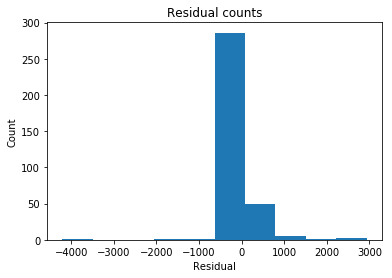

In [6]:
# check distribution of value

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = features['property_crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# view the residual
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

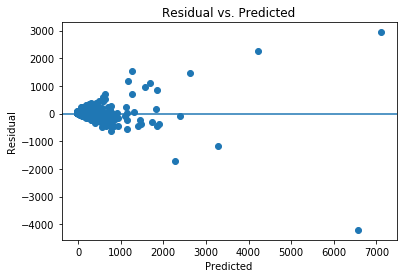

In [7]:
# check for homoscedascity
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

,pop,pop_sq,murder,robbery
pop,1.000,0.881,0.505,0.369
pop_sq,0.881,1.000,0.355,0.171
murder,0.505,0.355,1.000,0.308
robbery,0.369,0.171,0.308,1.000


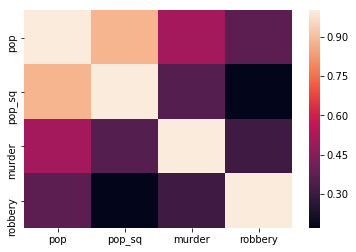

In [8]:
# check for correlation
correlation_matrix = X.corr()
display(correlation_matrix)
sns.heatmap(X.corr());

Our model definitely shows some correlation between the `pop` and `pop_sq` variables (which can be expected, they're derived from the same data!) and our model has some issues with homoscedascity and variable non-normality.

We can improve our model by dropping one of the correlated variables.
We should see our heteroscedascity and non-normality issues clear up with a log transformation.

In [19]:
# add 1 to property crime and perform a log transformation
features['log_pcrime'] = np.log1p(features['property_crime'])

# drop pop_sq to avoid correlation
features = features.drop('pop_sq', axis=1)

# refit our model.
regr = linear_model.LinearRegression()
Y = features['log_pcrime'].values.reshape(-1, 1)
X = features[['murder','robbery', 'pop']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[4.33054201e-01 1.68249309e+00 2.85977599e-05]]

Intercept: 
 [3.196656]

R-squared:
0.6598428356268384


The second iteraton of our model improves on some issues from the first iteration of our model.
Hopefully we'll see our issues with correlation, heteroscedascity, and non-normality clear up (we'll test for that later), but at a glance we can see this iteration is a clear an improvement.

Our previous model had a negative intercept (`Intercept: [-35.45330011]`), but our current model has an more logical intercept (`Intercept: [3.196656]`).
This makes far more sense, as a negative intercept implies a negative baseline for property crime, or without any of these other variables (murder, robberies) we would have a negative natural crime rate.
Wouldn't that be great!
Unfortunately, this is likely not the case, so a positve intercept means we're likely seeing an improvement in our model.

While we have made some improvements, our current model has a lower R-squared (`R-squared: 0.6598428356268384`) than the first iteration of our model (`R-squared: 0.7572767492306005`).
Let's see if we can get this to creep up a little bit.

Formula for the second iteration of our linear regression:
$$ log(Property Crime) = \alpha + Population + Murder + Robbery$$

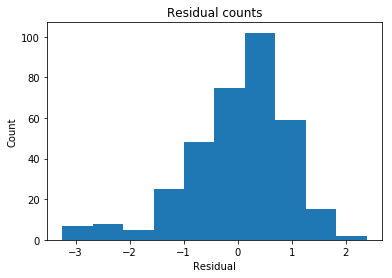

In [10]:
# compare value distribution of 'log_pcrime'

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = features['log_pcrime']

# Calculate the error, also called the residual.
residual = actual - predicted

# view the residual
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

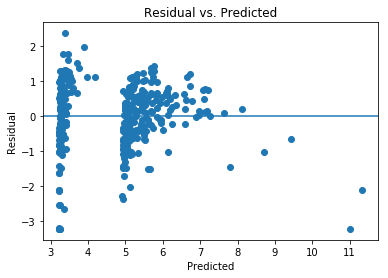

In [11]:
# compare homoscedascity of 'log_pcrime'
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

,murder,robbery,pop
murder,1.000,0.308,0.505
robbery,0.308,1.000,0.369
pop,0.505,0.369,1.000


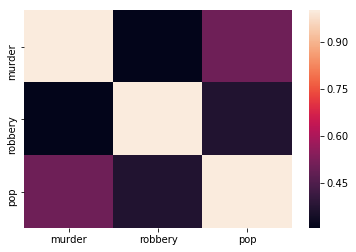

In [12]:
# compare correlation of 'log_pcrime'
correlation_matrix = X.corr()
display(correlation_matrix)
sns.heatmap(X.corr());

This correlation map looks much better, it looks like we cleared up our issue with `pop` and `pop_sq`.

Let's see if we can improve our model's performance by performing a log transformation on the population data instead of squaring it.

In [27]:
# Write out the model formula

linear_formula = 'property_crime ~ murder+robbery+pop'

# Fit the model to our data using the formula
lm = smf.ols(formula=linear_formula, data=features).fit()

display(lm.params, lm.pvalues, lm.rsquared, lm.conf_int())

Intercept   -81.918
murder      112.532
robbery     -27.156
pop           0.028
dtype: float64

Intercept   0.022
murder      0.141
robbery     0.583
pop         0.000
dtype: float64

0.7368948637920989

,0,1
Intercept,-151.732,-12.105
murder,-37.338,262.402
robbery,-124.460,70.148
pop,0.026,0.031


In [20]:
# perform a log transformation on the population data
features['log_pop'] = np.log1p(features['pop'])

features.head()

,property_crime,pop,murder,robbery,log_pcrime,log_pop
0,12.000,1861.000,0.000,0.000,2.565,7.529
1,24.000,2577.000,0.000,0.000,3.219,7.855
2,16.000,2846.000,0.000,0.000,2.833,7.954
3,4090.000,97956.000,1.000,1.000,8.317,11.492
4,223.000,6388.000,0.000,1.000,5.412,8.762


In [23]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = features['log_pcrime'].values.reshape(-1, 1)
X = features[['murder','robbery', 'log_pop']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[0.24770183 0.89431401 0.93424803]]

Intercept: 
 [-4.20945991]

R-squared:
0.786688138594454


This model looks much better!

Not only have we cleared up our issues with correlation, heterscedascity, and non-normality, we've even improved our R-Squared (`R-squared: 0.786688138594454`) above the first iteration of our model (`R-squared: 0.7572767492306005`).

Let's perform a cross validation on our model and confirm its performance. 

Formula for the third iteration of our linear regression:
$$ log(Property Crime) = \alpha + log(Population) + Murder + Robbery$$

,murder,robbery,log_pop
murder,1.000,0.308,0.478
robbery,0.308,1.000,0.599
log_pop,0.478,0.599,1.000


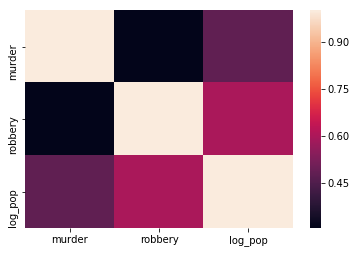

In [24]:
#check for correlation
correlation_matrix = X.corr()
display(correlation_matrix)
sns.heatmap(X.corr());

In [32]:
linear_formula = 'log_pcrime ~ murder+robbery+log_pop'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=features).fit()

display(lm.params, lm.pvalues, lm.rsquared, lm.conf_int())

Intercept   -4.209
murder       0.248
robbery      0.894
log_pop      0.934
dtype: float64

Intercept   0.000
murder      0.068
robbery     0.000
log_pop     0.000
dtype: float64

0.786688138594454

,0,1
Intercept,-4.964,-3.455
murder,-0.019,0.514
robbery,0.690,1.098
log_pop,0.842,1.027


In [33]:
# cross validate our model
from sklearn.model_selection import train_test_split
from sklearn import linear_model

data = features.drop('log_pcrime', axis=1)
target = features.log_pcrime

reg = linear_model.LinearRegression()
reg.fit(data, target)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5, random_state=20)
print('20% Holdout: ' + str(reg.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(reg.fit(data, target).score(data, target)))

20% Holdout: 0.7959358597722009
Testing on Sample: 0.8131025236182239


Our model's performance looks consistent across our cross valiadtion and we can see from our heatmap that our model exhibits no correlation.

Based on our adjustments, our model can predict `Property Crime` with an ~80% success rate.

Formula for the final iteration of our linear regression:
$$ log(Property Crime) = \alpha + log(Population) + Murder + Robbery$$